# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential
from matplotlib import pyplot

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Train-test-split and Normalization

In [4]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

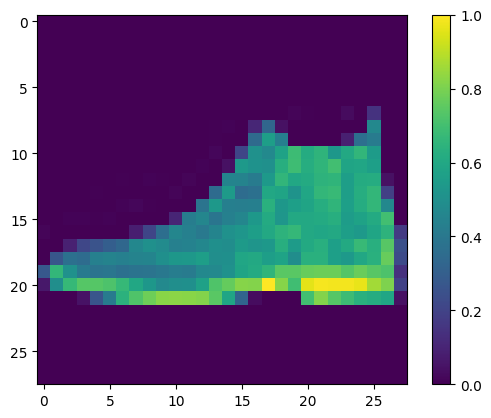

In [6]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

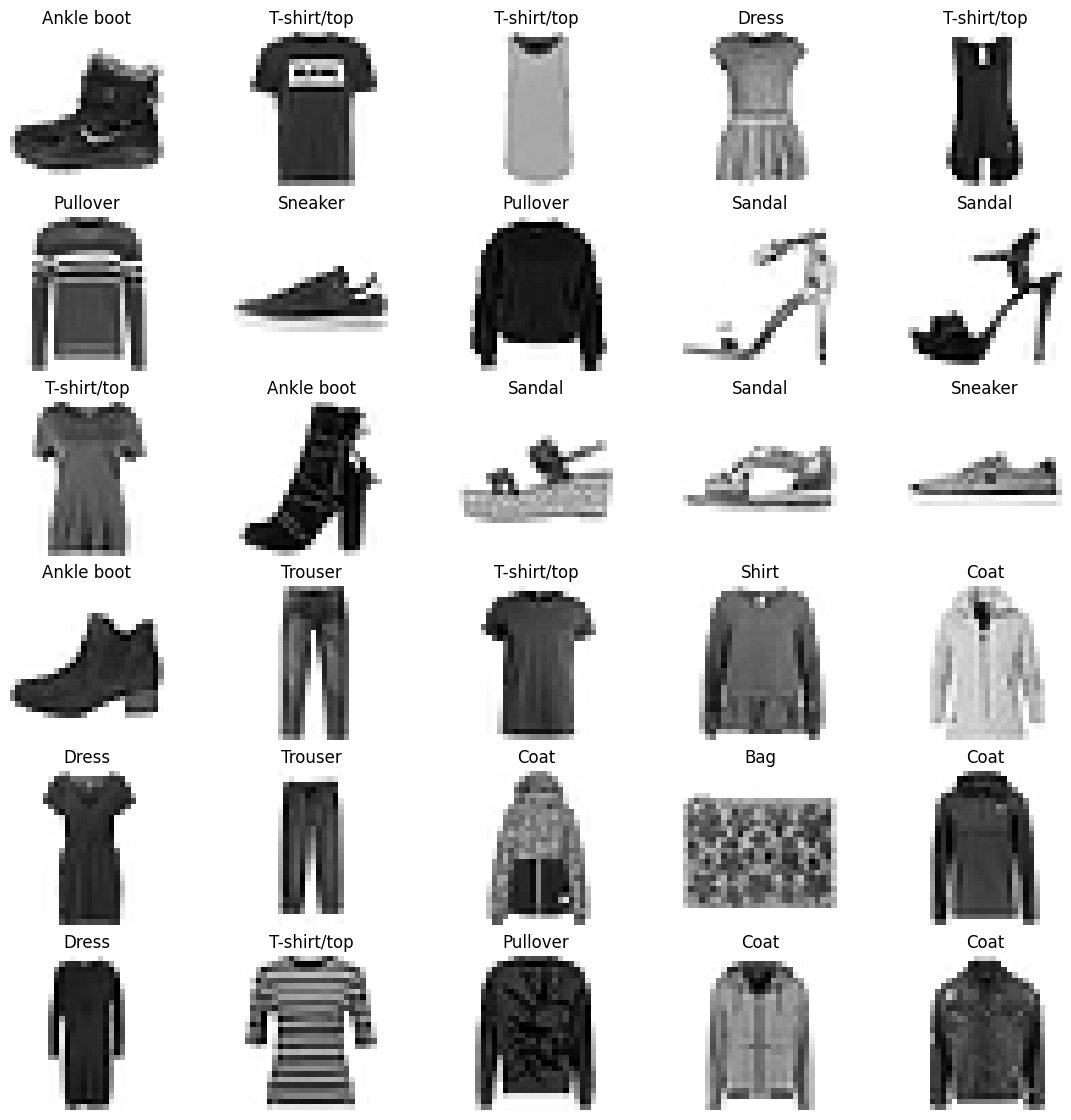

In [7]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

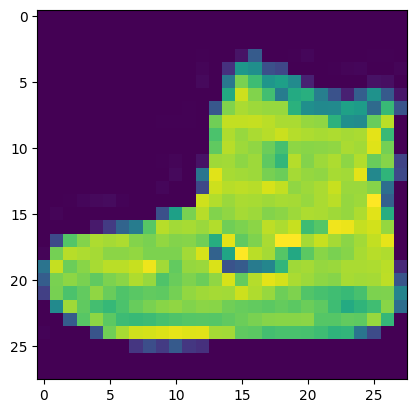

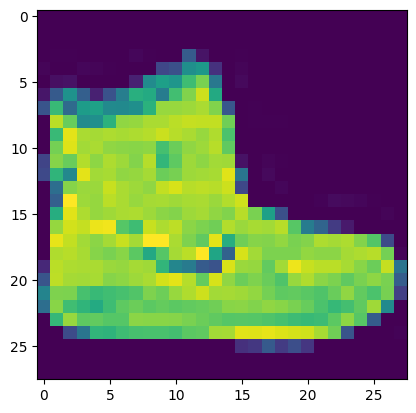

In [8]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


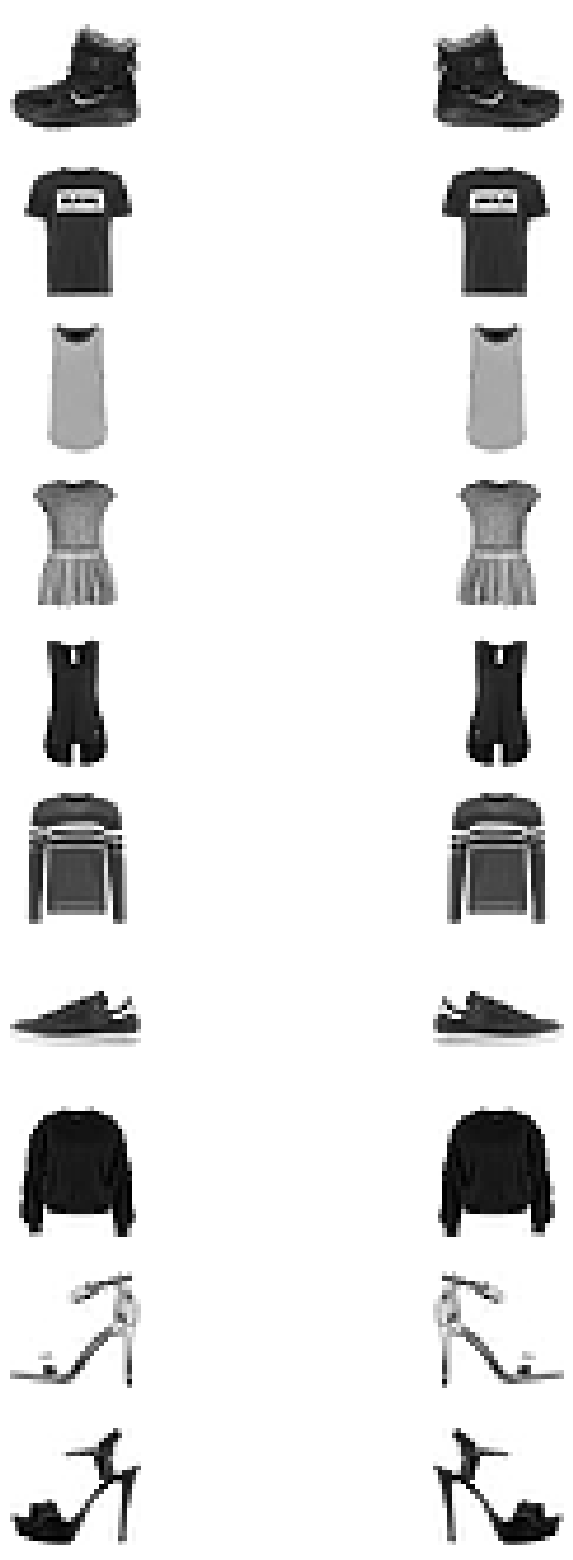

In [9]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

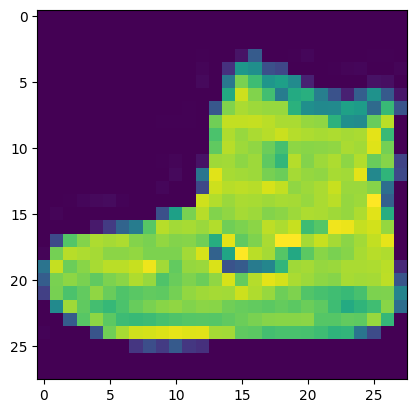

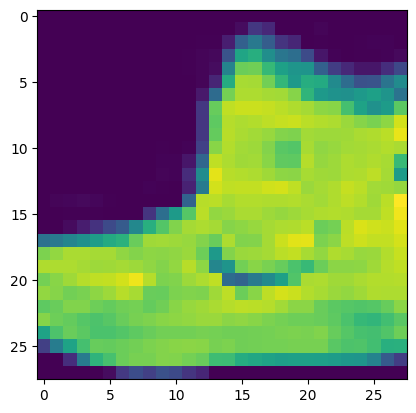



(54000, 28, 28)


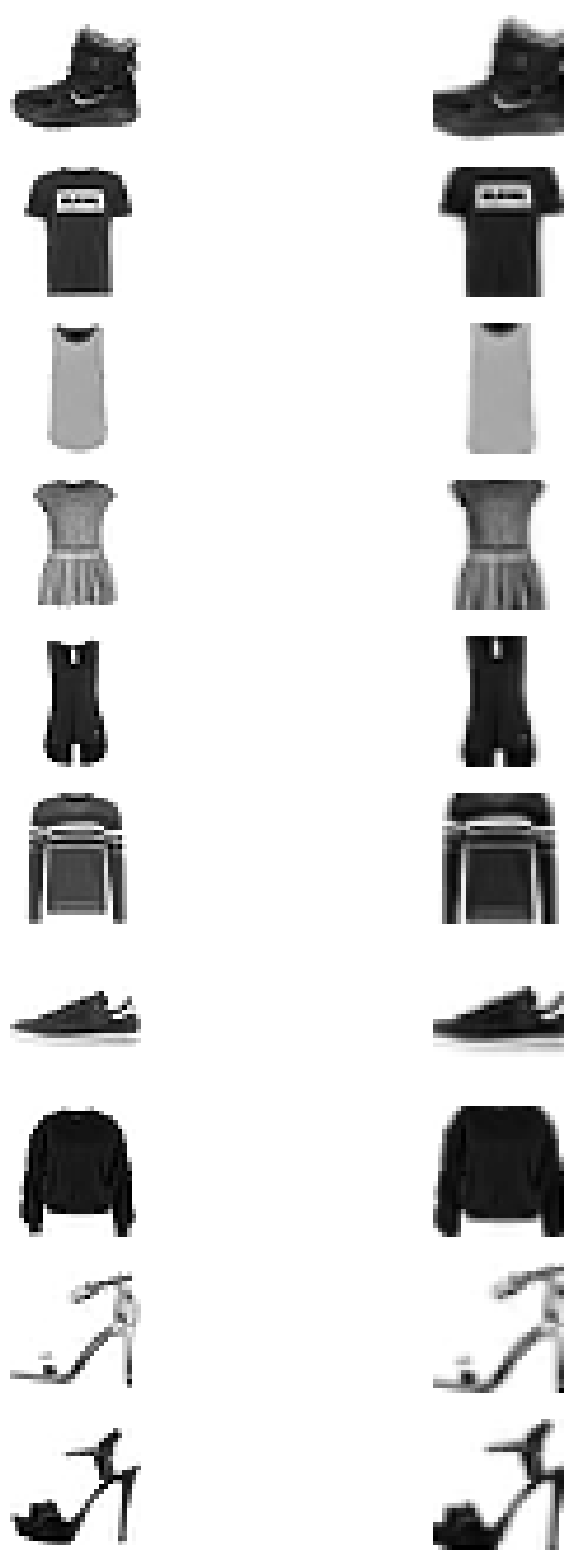

In [10]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [11]:
baseline_model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(28, 28, 1)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(16, activation="relu"),
    layers.Dense(10)
])

baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_model.summary())
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
baseline_model_history = baseline_model.fit(x_train, y_train, 
                                                epochs=10, 
                                                validation_data=(x_val, y_val),
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

baseline_model_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 flatten (Flatten)           (None, 23328)             0         
                                                                 
 dense (Dense)               (None, 16)                373264    
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 373,594
Trainable params: 373,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1688/1688 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.7940
Epoch 1: saving model to tmp/checkpoint\baseline.hdf5

Epoch 1: val_accuracy im

In [12]:
# evaluating baseline coarse model
print(baseline_model.evaluate(x_test, y_test))
baseline_model.load_weights('tmp/checkpoint/baseline_Acc.hdf5')
scoreAcc = baseline_model.evaluate(x_test, y_test)
baseline_model.load_weights('tmp/checkpoint/baseline_Loss.hdf5')
scoreLoss = baseline_model.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.3346 - accuracy: 0.8958
[0.3346185088157654, 0.895799994468689]
313/313 [==============================] - 1s 3ms/step - loss: 0.3062 - accuracy: 0.8983
Best Acc Test Loss: 0.30624571442604065
Best Acc Test Accuracy: 89.83 %
Best Loss Test Loss: 0.30624571442604065
Best Loss Test Accuracy: 89.83 %


## Baseline Training and validation Accuracy

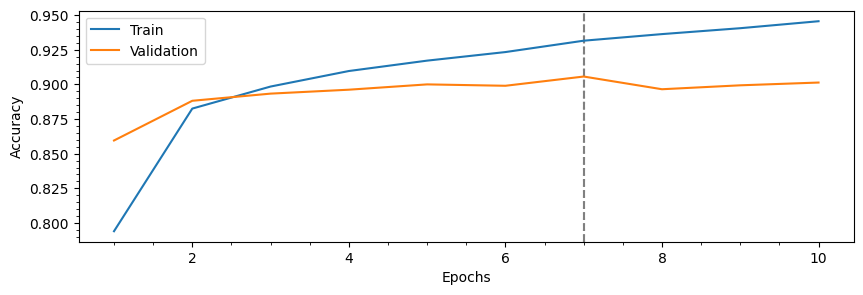

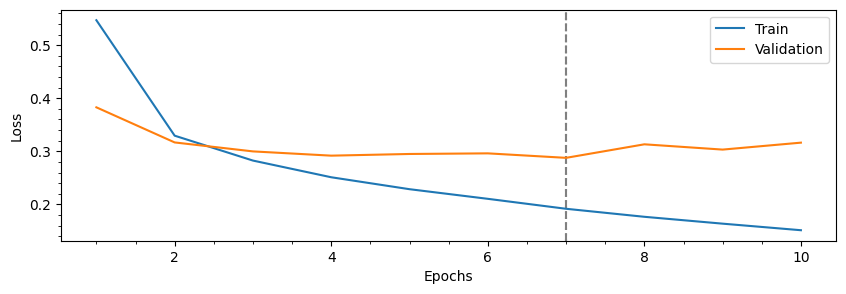

In [13]:
max_val_acc_epoch = np.argmax(list(baseline_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_model_history.history['val_loss']))+1
epochs = range(1, len(baseline_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_model_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_model_history.history['loss'], label='Train')
plt.plot(epochs,baseline_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

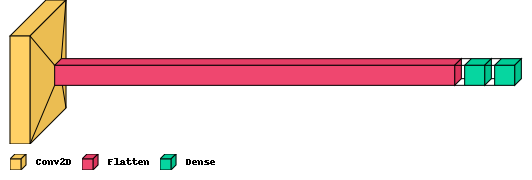

In [14]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_model, legend=True)

In [15]:
# model.save_weights("./tmp/fashion-baseline-model.h5")

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Own model

In [16]:
own_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),  
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),  
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(own_model.summary())
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/ownModel.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/ownModelAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/ownModelLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
own_model_history = own_model.fit(x_train, y_train, 
                                                epochs=20, 
                                                validation_data=(x_val, y_val), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

own_model_history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)         

In [17]:
# evaluating baseline coarse model
print(own_model.evaluate(x_test, y_test))
own_model.load_weights('tmp/checkpoint/ownModelAcc.hdf5')
scoreAcc = own_model.evaluate(x_test, y_test)
own_model.load_weights('tmp/checkpoint/ownModelLoss.hdf5')
scoreLoss = own_model.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2845 - accuracy: 0.9197
[0.28450754284858704, 0.919700026512146]
313/313 [==============================] - 1s 3ms/step - loss: 0.2354 - accuracy: 0.9207
Best Acc Test Loss: 0.2354094535112381
Best Acc Test Accuracy: 92.07 %
Best Loss Test Loss: 0.2354094535112381
Best Loss Test Accuracy: 92.07 %


## Own model Training and validation Accuracy & Loss

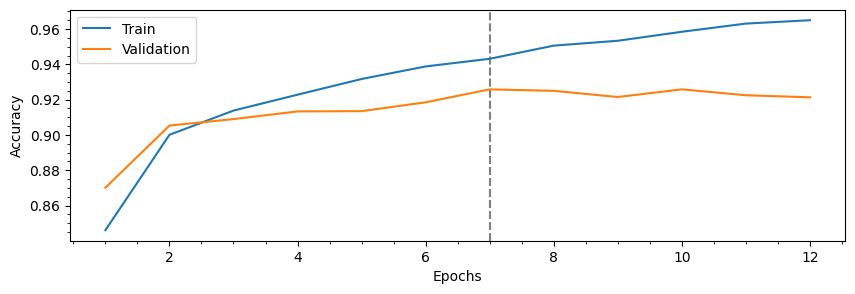

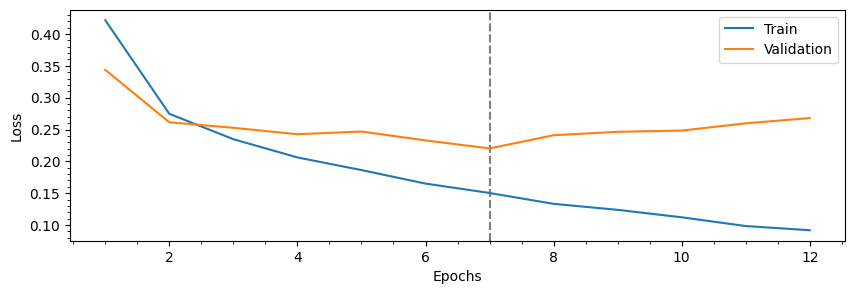

In [18]:
max_val_acc_epoch = np.argmax(list(own_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(own_model_history.history['val_loss']))+1
epochs = range(1, len(own_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_model_history.history['accuracy'], label='Train')
plt.plot(epochs,own_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_model_history.history['loss'], label='Train')
plt.plot(epochs,own_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

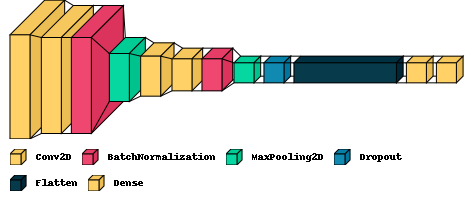

In [19]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_model, legend=True)

In [20]:
# own_model.save_weights("./models/fashion-own-model.h5")

<h3><b>4. Model Improvement with augmented data</h3></b>

In [21]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [22]:
baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_augmented.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_augmentedAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_augmentedLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, 
                                                epochs=10, 
                                                validation_data=(x_val, y_val), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])


baseline_augmented_history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               5120128   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5054/5063 [============================>.] - ETA: 0s - loss: 0.3608 - accuracy: 0.8690
Epoch 1: saving model to tmp/checkpoint\baseline_augmented.hdf5

Epoch 1:

In [23]:
# evaluating baseline coarse model
print(baseline_augmented_model.evaluate(x_test, y_test))
baseline_augmented_model.load_weights('tmp/checkpoint/baseline_augmentedAcc.hdf5')
scoreAcc = baseline_augmented_model.evaluate(x_test, y_test)
baseline_augmented_model.load_weights('tmp/checkpoint/baseline_augmentedLoss.hdf5')
scoreLoss = baseline_augmented_model.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.5111 - accuracy: 0.9056
[0.5111310482025146, 0.9056000113487244]
313/313 [==============================] - 1s 3ms/step - loss: 0.2824 - accuracy: 0.9045
Best Acc Test Loss: 0.28241217136383057
Best Acc Test Accuracy: 90.45 %
Best Loss Test Loss: 0.28241217136383057
Best Loss Test Accuracy: 90.45 %


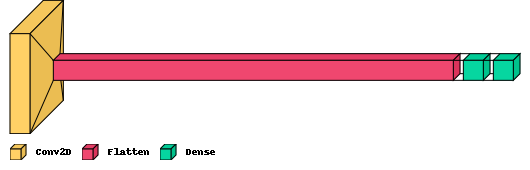

In [24]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_augmented_model, legend=True)

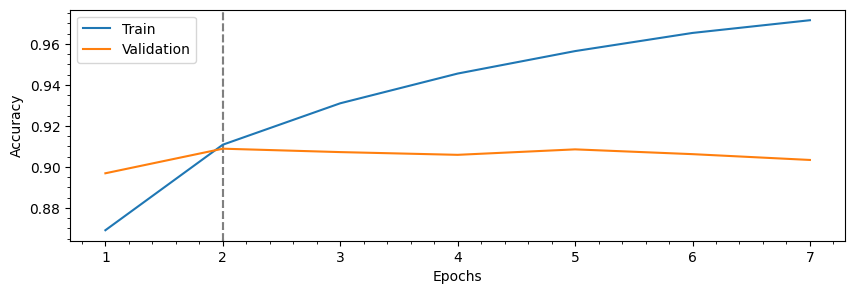

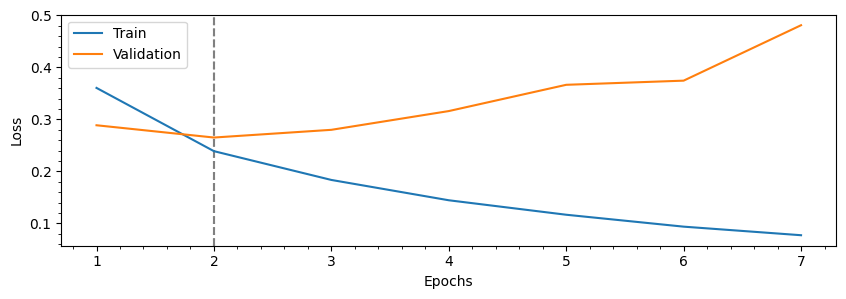

In [25]:
max_val_acc_epoch = np.argmax(list(baseline_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_augmented_history.history['val_loss']))+1
epochs = range(1, len(baseline_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_augmented_history.history['loss'], label='Train')
plt.plot(epochs,baseline_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# baseline_augmented_model.save_weights("./models/fashion_baseline_augmented_model.h5")

In [27]:
own_augmented_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),  
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),  
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_augmented_model.summary())
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_augmented.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_augmentedAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_augmentedLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
history_augmented = own_augmented_model.fit(x_train_augmented, y_train_augmented, 
                                                epochs=10, 
                                                validation_data=(x_val, y_val), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

history_augmented

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)         

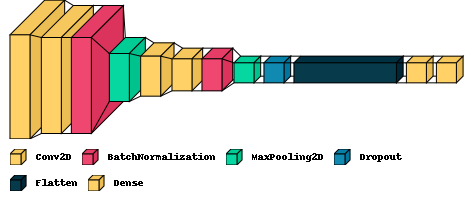

In [28]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_augmented_model, legend=True)

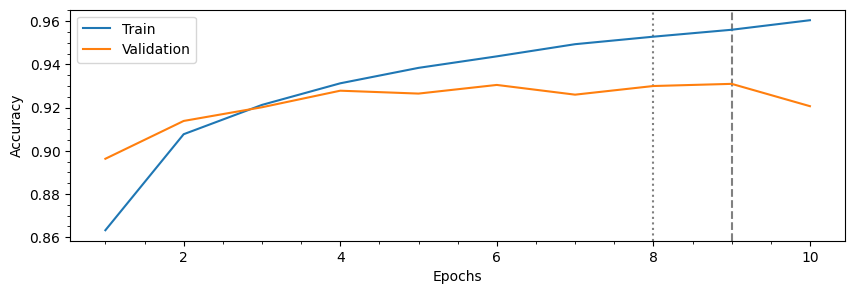

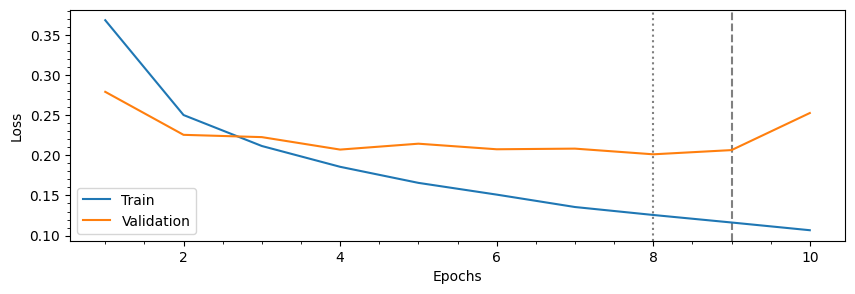

In [29]:
max_val_acc_epoch = np.argmax(list(history_augmented.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(history_augmented.history['val_loss']))+1
epochs = range(1, len(history_augmented.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['accuracy'], label='Train')
plt.plot(epochs,history_augmented.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['loss'], label='Train')
plt.plot(epochs,history_augmented.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# evaluating baseline coarse model
print(own_augmented_model.evaluate(x_test, y_test))
own_augmented_model.load_weights('tmp/checkpoint/own_augmentedAcc.hdf5')
scoreAcc = own_augmented_model.evaluate(x_test, y_test)
own_augmented_model.load_weights('tmp/checkpoint/own_augmentedLoss.hdf5')
scoreLoss = own_augmented_model.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2920 - accuracy: 0.9194
[0.292044073343277, 0.9193999767303467]
313/313 [==============================] - 1s 3ms/step - loss: 0.2208 - accuracy: 0.9266
Best Acc Test Loss: 0.23830924928188324
Best Acc Test Accuracy: 92.55 %
Best Loss Test Loss: 0.2208051234483719
Best Loss Test Accuracy: 92.66 %


In [31]:
# own_augmented_model.save_weights("models/fashion-own-augmented-model.h5")

## Hyperparameter tuning

In [32]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1))), 
  # model.add(keras.layers.Flatten()),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),  
  model.add(keras.layers.BatchNormalization()),
  model.add(keras.layers.MaxPooling2D((2, 2))),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),  
  model.add(keras.layers.BatchNormalization()),  
  model.add(keras.layers.MaxPooling2D((2, 2))),
  model.add(keras.layers.Dropout(0.2)),
  model.add(keras.layers.Flatten()), # 2d to 1d
  model.add(keras.layers.Dense(64, activation="relu")),
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [33]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [35]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [36]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.4503 - accuracy: 0.8330 - val_loss: 0.3449 - val_accuracy: 0.8763
Epoch 2/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.3050 - accuracy: 0.8863 - val_loss: 0.3335 - val_accuracy: 0.8782
Epoch 3/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2632 - accuracy: 0.9037 - val_loss: 0.3229 - val_accuracy: 0.8780
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2352 - accuracy: 0.9140 - val_loss: 0.2663 - val_accuracy: 0.9041
Epoch 5/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2147 - accuracy: 0.9210 - val_loss: 0.2765 - val_accuracy: 0.9045
Epoch 6/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.1975 - accuracy: 0.9271 - val_loss: 0.2653 - val_accuracy: 0.9068
Epoch 7/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.1812 - accuracy: 0.9332 - val_loss: 0.2479 - val_accuracy:

In [37]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hyper.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hyperAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hyperLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
hypermodel_history = hypermodel.fit(x_train, y_train, 
                                                epochs=10, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])
hypermodel_history

Epoch 1/10
1682/1688 [============================>.] - ETA: 0s - loss: 0.4357 - accuracy: 0.8399
Epoch 1: saving model to tmp/checkpoint\hyper.hdf5

Epoch 1: val_accuracy improved from -inf to 0.86760, saving model to tmp/checkpoint\hyperAcc.hdf5

Epoch 1: val_loss improved from inf to 0.35649, saving model to tmp/checkpoint\hyperLoss.hdf5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.4357 - accuracy: 0.8399 - val_loss: 0.3565 - val_accuracy: 0.8676
Epoch 2/10
1685/1688 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8917
Epoch 2: saving model to tmp/checkpoint\hyper.hdf5

Epoch 2: val_accuracy improved from 0.86760 to 0.88870, saving model to tmp/checkpoint\hyperAcc.hdf5

Epoch 2: val_loss improved from 0.35649 to 0.29192, saving model to tmp/checkpoint\hyperLoss.hdf5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2928 - accuracy: 0.8917 - val_loss: 0.2919 - val_accuracy: 0.8887
Epoch 3/10
1683/1688 [=================

In [38]:
# evaluating baseline coarse model
print(hypermodel.evaluate(x_test, y_test))
hypermodel.load_weights('tmp/checkpoint/hyperAcc.hdf5')
scoreAcc = hypermodel.evaluate(x_test, y_test)
hypermodel.load_weights('tmp/checkpoint/hyperLoss.hdf5')
scoreLoss = hypermodel.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2546 - accuracy: 0.9229
[0.2545602321624756, 0.9229000210762024]
313/313 [==============================] - 1s 4ms/step - loss: 0.2198 - accuracy: 0.9246
Best Acc Test Loss: 0.22901596128940582
Best Acc Test Accuracy: 92.47 %
Best Loss Test Loss: 0.21979521214962006
Best Loss Test Accuracy: 92.46 %


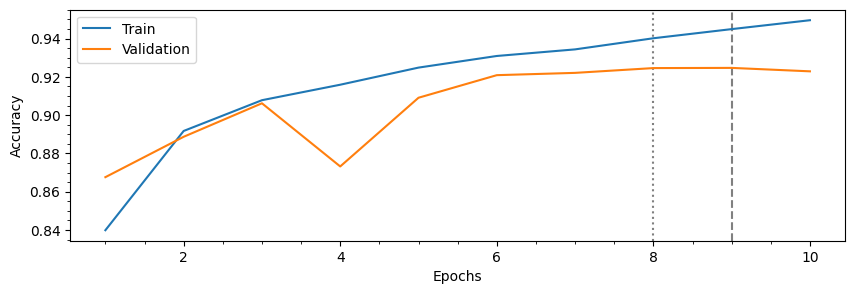

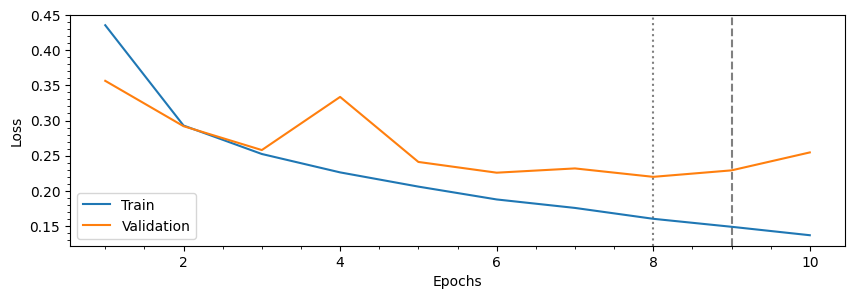

In [39]:
max_val_acc_epoch = np.argmax(list(hypermodel_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

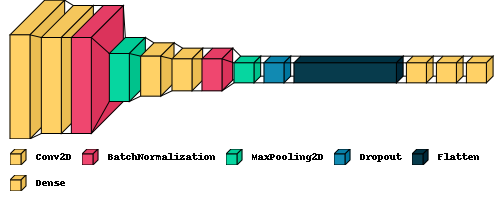

In [40]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel, legend=True)

In [41]:
# hypermodel.save_weights("./tmp/fashion_hyper_model.h5")

In [42]:
tuner.search(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [43]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_augmented, y_train_augmented, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
4050/4050 [==============================] - 25s 6ms/step - loss: 0.3936 - accuracy: 0.8546 - val_loss: 0.3999 - val_accuracy: 0.8481
Epoch 2/20
4050/4050 [==============================] - 24s 6ms/step - loss: 0.2712 - accuracy: 0.9000 - val_loss: 0.3146 - val_accuracy: 0.8831
Epoch 3/20
4050/4050 [==============================] - 24s 6ms/step - loss: 0.2332 - accuracy: 0.9147 - val_loss: 0.2817 - val_accuracy: 0.8960
Epoch 4/20
4050/4050 [==============================] - 24s 6ms/step - loss: 0.2077 - accuracy: 0.9229 - val_loss: 0.2822 - val_accuracy: 0.8977
Epoch 5/20
4050/4050 [==============================] - 24s 6ms/step - loss: 0.1898 - accuracy: 0.9297 - val_loss: 0.2971 - val_accuracy: 0.8896
Epoch 6/20
4050/4050 [==============================] - 24s 6ms/step - loss: 0.1758 - accuracy: 0.9343 - val_loss: 0.2364 - val_accuracy: 0.9137
Epoch 7/20
4050/4050 [==============================] - 25s 6ms/step - loss: 0.1638 - accuracy: 0.9382 - val_loss: 0.2457 - val_ac

In [44]:
hypermodel_augmented = tuner.hypermodel.build(best_hps)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hypermodelAugmented.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hypermodelAugmentedAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/hypermodelAugmentedLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
hypermodel_augmented_history = hypermodel_augmented.fit(x_train_augmented, y_train_augmented, 
                                                epochs=10, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])
hypermodel_augmented_history

Epoch 1/10
5062/5063 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.8616
Epoch 1: saving model to tmp/checkpoint\hypermodelAugmented.hdf5

Epoch 1: val_accuracy improved from -inf to 0.89330, saving model to tmp/checkpoint\hypermodelAugmentedAcc.hdf5

Epoch 1: val_loss improved from inf to 0.29328, saving model to tmp/checkpoint\hypermodelAugmentedLoss.hdf5
5063/5063 [==============================] - 32s 6ms/step - loss: 0.3741 - accuracy: 0.8616 - val_loss: 0.2933 - val_accuracy: 0.8933
Epoch 2/10
5060/5063 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9034
Epoch 2: saving model to tmp/checkpoint\hypermodelAugmented.hdf5

Epoch 2: val_accuracy improved from 0.89330 to 0.91130, saving model to tmp/checkpoint\hypermodelAugmentedAcc.hdf5

Epoch 2: val_loss improved from 0.29328 to 0.24398, saving model to tmp/checkpoint\hypermodelAugmentedLoss.hdf5
5063/5063 [==============================] - 31s 6ms/step - loss: 0.2624 - accuracy: 0.90

In [45]:
# evaluating baseline coarse model
print(hypermodel_augmented.evaluate(x_test, y_test))
hypermodel_augmented.load_weights('tmp/checkpoint/hypermodelAugmentedAcc.hdf5')
scoreAcc = hypermodel_augmented.evaluate(x_test, y_test)
hypermodel_augmented.load_weights('tmp/checkpoint/hypermodelAugmentedLoss.hdf5')
scoreLoss = hypermodel_augmented.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 4ms/step - loss: 0.2237 - accuracy: 0.9279
[0.223718523979187, 0.9279000163078308]
313/313 [==============================] - 1s 4ms/step - loss: 0.2027 - accuracy: 0.9249
Best Acc Test Loss: 0.20288674533367157
Best Acc Test Accuracy: 93.08 %
Best Loss Test Loss: 0.2027376890182495
Best Loss Test Accuracy: 92.49000000000001 %


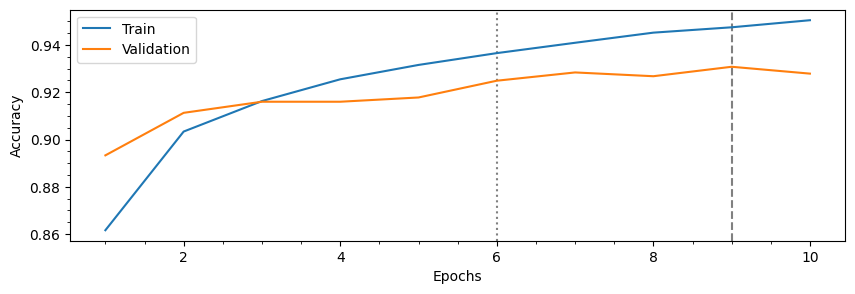

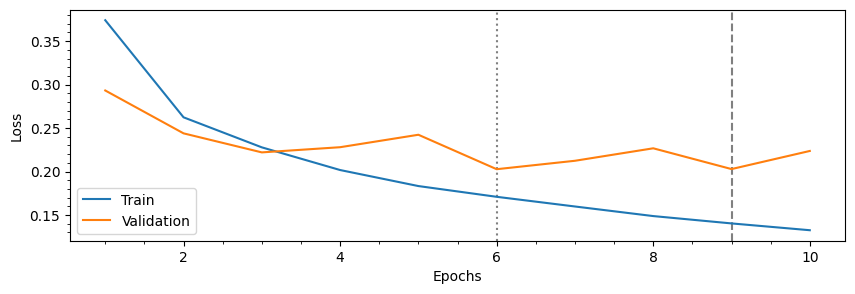

In [46]:
max_val_acc_epoch = np.argmax(list(hypermodel_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_augmented_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# hypermodel.save_weights("./tmp/fashion_hyper_augmented_model.h5")

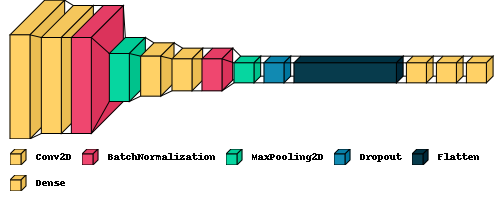

In [48]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel_augmented, legend=True)